In [25]:
############################################################################################################################################################
######################################################### PREPROCESSING ####################################################################################
############################################################################################################################################################

import os
import librosa
import numpy as np
from tqdm import tqdm

# Function to extract MFCC features from audio files
def extract_mfcc(audio_path, num_mfcc=25, n_fft=2048, hop_length=512):
    audio, sr = librosa.load(audio_path, sr=44100)  # Load audio file
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs

# Function to preprocess the dataset
def preprocess_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over the real and fake directories in the training, testing, and validation sets
    sets = ['training', 'testing', 'validation']
    categories = ['real', 'fake']
    for dataset in sets:
        for category in categories:
            input_category_dir = os.path.join(input_dir, dataset, category)
            output_category_dir = os.path.join(output_dir, dataset, category)
            if not os.path.exists(output_category_dir):
                os.makedirs(output_category_dir)

            # Process each audio file in the current category
            audio_files = os.listdir(input_category_dir)
            for audio_file in tqdm(audio_files, desc=f'Processing {dataset}/{category}', unit='audio'):
                input_audio_path = os.path.join(input_category_dir, audio_file)
                output_audio_path = os.path.join(output_category_dir, audio_file.replace('.wav', '.npy'))
                
                # Extract MFCC features and save to file
                mfccs = extract_mfcc(input_audio_path)
                np.save(output_audio_path, mfccs)

if __name__ == "__main__":
    input_dir = "FoR"  # Path to the directory containing the dataset
    output_dir = "preprocessed"  # Path to the directory where preprocessed data will be saved
    preprocess_dataset(input_dir, output_dir)


Processing validation/fake: 100%|██████████| 1413/1413 [00:31<00:00, 45.11audio/s]


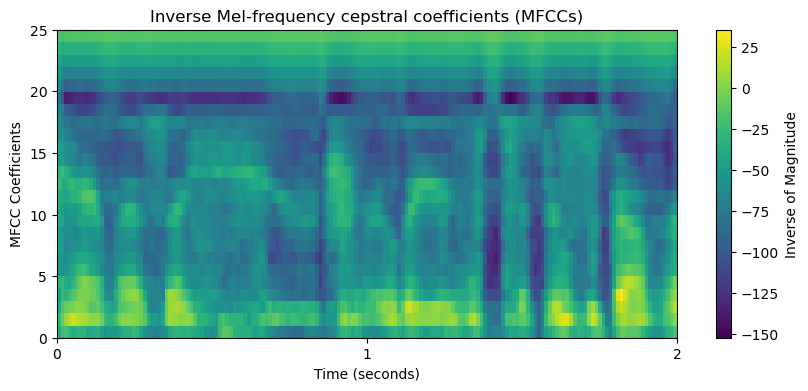

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Load the NPZ file
mfcc_data = np.load(
    "preprocessed\\training\\real\\file2.npy_16k.npy_norm.npy_mono.npy_silence.npy_2sec.npy")

# Extract the MFCC array with increased number of coefficients
mfcc_array = librosa.feature.mfcc(
    y=None, sr=16000, S=mfcc_data, n_mfcc=25)

# Calculate the inverse of the magnitude
inverse_magnitude = mfcc_array

# Calculate the time range
# Assuming each time step is 0.01 seconds
time_range = np.arange(inverse_magnitude.shape[1]) * 0.01

# Display the inverse of the MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(inverse_magnitude, cmap='viridis', origin='lower',
           aspect='auto', extent=[0, 2, 0, 25])  # Adjust extent for time range
plt.colorbar(label='Inverse of Magnitude')
plt.xlabel('Time (seconds)')
plt.ylabel('MFCC Coefficients')
plt.title('Inverse Mel-frequency cepstral coefficients (MFCCs)')
# Set xticks to integer values every 0.5 seconds
plt.xticks(np.arange(0, 2.1, 1))
plt.show()

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm
import os
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Bidirectional

# Function to load preprocessed data


def load_preprocessed_data(input_dir):
    data = []
    labels = []
    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for file in tqdm(os.listdir(category_dir), desc=f'Loading {category} data', unit='audio'):
                file_path = os.path.join(category_dir, file)
                features = np.load(file_path)
                # Add a new axis for the channel
                data.append(features[..., np.newaxis])
                # Assuming 'real' is the other category
                labels.append(1 if category == 'fake' else 0)
    return np.array(data), np.array(labels)




# Load preprocessed data
preprocessed_dir = 'preprocessed'
train_data, train_labels = load_preprocessed_data(
    os.path.join(preprocessed_dir, 'training'))
val_data, val_labels = load_preprocessed_data(
    os.path.join(preprocessed_dir, 'validation'))
test_data, test_labels = load_preprocessed_data(
    os.path.join(preprocessed_dir, 'testing'))

# Define model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',
                  input_shape=train_data.shape[1:]),
    layers.MaxPooling2D((2, 2), strides=(1, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(1, 1)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(1, 1)),
    layers.Flatten(),
    layers.Reshape((-1, 128)),  # Reshape to fit LSTM input
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    Dropout(0.9),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=20,
                    batch_size=32, validation_data=(val_data, val_labels))

Loading fake data:   0%|          | 0/6978 [00:00<?, ?audio/s]

Loading real data: 100%|██████████| 544/544 [00:03<00:00, 172.64audio/s]


Epoch 1/20
437/437 [==============================] - 113s 253ms/step - loss: 0.6402 - accuracy: 0.6182 - val_loss: 0.4655 - val_accuracy: 0.8093
Epoch 2/20
437/437 [==============================] - 115s 263ms/step - loss: 0.4524 - accuracy: 0.8090 - val_loss: 0.6610 - val_accuracy: 0.7215
Epoch 3/20
437/437 [==============================] - 117s 268ms/step - loss: 0.4089 - accuracy: 0.8356 - val_loss: 0.2936 - val_accuracy: 0.8850
Epoch 4/20
437/437 [==============================] - 117s 267ms/step - loss: 0.3026 - accuracy: 0.8865 - val_loss: 0.1858 - val_accuracy: 0.9285
Epoch 5/20
437/437 [==============================] - 111s 254ms/step - loss: 0.2500 - accuracy: 0.9120 - val_loss: 0.1776 - val_accuracy: 0.9296
Epoch 6/20
437/437 [==============================] - 110s 253ms/step - loss: 0.2006 - accuracy: 0.9342 - val_loss: 0.2342 - val_accuracy: 0.9112
Epoch 7/20
437/437 [==============================] - 110s 252ms/step - loss: 0.1578 - accuracy: 0.9491 - val_loss: 0.1437 -

In [7]:

##### ERROR CODE###
##### DONT RUN IT #####


import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Bidirectional

# Function to load preprocessed data
def load_preprocessed_data(input_dir):
    data = []
    labels = []
    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for file in tqdm(os.listdir(category_dir), desc=f'Loading {category} data', unit='audio'):
                file_path = os.path.join(category_dir, file)
                features = np.load(file_path)
                data.append(features[..., np.newaxis])  # Add a new axis for the channel
                labels.append(1 if category == 'fake' else 0)  # Assuming 'real' is the other category
    return np.array(data), np.array(labels)

# Load preprocessed data
preprocessed_dir = 'preprocessed'
train_data, train_labels = load_preprocessed_data(os.path.join(preprocessed_dir, 'training'))

# Split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Define model architecture

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_data.shape[1:]),
    layers.MaxPooling2D((2, 2), strides=(1, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(1, 1)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(1, 1)),
    layers.Flatten(),
    layers.Reshape((-1, 128)),  # Reshape to fit LSTM input
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    Dropout(0.9),
    layers.Dense(1, activation='sigmoid')
])

# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_data.shape[1:]),
#     layers.MaxPooling2D((2, 2), strides=(1, 1)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2), strides=(1, 1)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2), strides=(1, 1)),
#     layers.Flatten(),
#     layers.Reshape((-1, 128)),  # Reshape to fit BiLSTM input
#     layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),  # Add BiLSTM layer
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),  # Add dropout after the Dense layer
#     layers.Dense(1, activation='sigmoid')
# ])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(val_data, val_labels))


Loading fake data:   0%|          | 2/20934 [00:00<00:10, 1959.04audio/s]


KeyError: '(Ellipsis, None) is not a file in the archive'

In [28]:
# Load preprocessed validation data
val_data, val_labels = load_preprocessed_data(os.path.join(preprocessed_dir, 'validation'))

# Evaluate the model on validation set
val_loss, val_acc = model.evaluate(val_data, val_labels)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


Loading real data: 100%|██████████| 1413/1413 [00:00<00:00, 4025.06audio/s]


89/89 [==============================] - 10s 108ms/step - loss: 0.0508 - accuracy: 0.9827
Validation Loss: 0.05080297216773033
Validation Accuracy: 0.9826610088348389


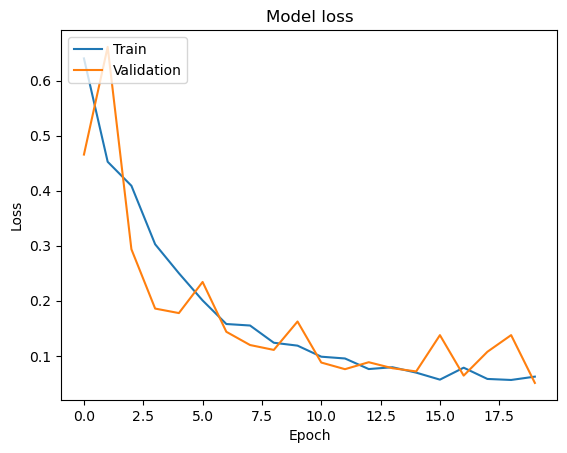

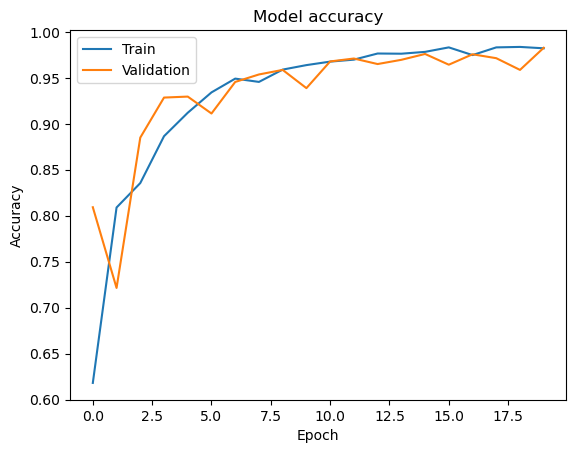

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [5]:
print(f'Test accuracy: {test_acc}')

NameError: name 'test_acc' is not defined

In [32]:
model.save('Models/deepfake_audio_detection_model.h5')

In [33]:
loaded_model = models.load_model("Models/deepfake_audio_detection_model.h5")
test_data, test_labels = load_preprocessed_data(
    os.path.join(preprocessed_dir, 'testing'))
test_loss, test_accuracy = loaded_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Loading real data: 100%|██████████| 544/544 [00:00<00:00, 3038.93audio/s]


34/34 [==============================] - 4s 96ms/step - loss: 0.8775 - accuracy: 0.7574
Test Loss: 0.8775380849838257
Test Accuracy: 0.7573529481887817
